## List of tables:
### 1. [Table 3: Share of selfish choices](#decision)

## List of figures:
### 2. [Figure 1: Share of player X who choose the selfish option](#decision_plot)

In [1]:
%matplotlib inline

#### Imports libraries

In [2]:
import matplotlib.pyplot as plt  # Plotting
import os  # File system handling
import pandas as pd  # Dataframe handling
import statsmodels.formula.api as smf  # Regressions analysis

from matplotlib.ticker import FuncFormatter  # Formating graphs
from itertools import combinations
from statsmodels.iolib.summary2 import summary_col  # Regression output table
from statsmodels.stats.proportion import proportions_ztest # Proportion Z-test

#### Set project directory

In [3]:
PROJECT_FOLDER = os.path.dirname(os.getcwd())
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Pandas options

In [4]:
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 40)

#### Set plotting style

In [5]:
plt.style.use('classic')

#### Set plotting properties 

In [6]:
bar_kw = dict(kind='bar', color='0.4')
line_kw = dict(kind='line', lw=1, alpha=1, legend=True)
font_kw = dict(fontsize=11, color='k')
grid_kw = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlab_kw = dict(fontsize=11, labelpad=3)
ylab_kw = dict(fontsize=11, labelpad=3)
error_kw = dict(elinewidth=2, ecolor='0.15')
legend_kw = dict(frameon=False)
tick_kw = dict(size=5,
               which='both',
               direction='out',
               right=False,
               top=False,
               labelbottom=True)

#### Retrieving dataframe

In [7]:
DATA = os.path.join(
    FINAL_DATA_FOLDER, 
    'fair_advice_final.feather'
)

df = pd.read_feather(DATA)

#### Select only player X (dictators) and treatments with risly outcomes

In [8]:
df = df[(df['Dictator'] == 1) & (df['Risk'] == 1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 1800 to 3595
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Dataset                   896 non-null    int64         
 1   SubmitTime                896 non-null    datetime64[ns]
 2   Duration                  896 non-null    int64         
 3   Controlquestion           896 non-null    float64       
 4   Controlquestion_attempts  896 non-null    float64       
 5   Treatment                 896 non-null    int64         
 6   Treatment_name            896 non-null    object        
 7   Dictator                  896 non-null    int64         
 8   Decision                  896 non-null    int64         
 9   Advise                    0 non-null      float64       
 10  Follow                    0 non-null      float64       
 11  Belief1                   296 non-null    float64       
 12  Belief2           

#### Group datasets according to treatments

In [9]:
grouped_advice = df.groupby('Advice_type')

#### Control questions

In [10]:
grouped_advice['Controlquestion_attempts'].value_counts()

Advice_type  Controlquestion_attempts
Base         0.0                         299
Binding      0.0                         301
Free         0.0                         296
Name: Controlquestion_attempts, dtype: int64

#### Share of player X choosing the sefish option, risky outcomes

In [11]:
decision_advice = grouped_advice['Decision']\
    .agg(['mean', 'sem', 'count'])\
    .rename(lambda x: x.capitalize(), axis=0)

display(decision_advice)

,mean,sem,count
Advice_type,,,
Base,0.559,0.029,299
Binding,0.548,0.029,301
Free,0.409,0.029,296


#### Pairwise proportion Z-test for share of selfish choices

In [12]:
for group_1, group_2 in combinations(['Base', 'Binding', 'Free'], 2):
    nobs = ((df[f'{group_1}'] == 1).sum()), ((df[f'{group_2}'] == 1).sum())
    count_selfish = df[df[f'{group_1}'] == 1]['Decision'].sum(), df[df[f'{group_2}'] == 1]['Decision'].sum()
    zstat, pvalue = proportions_ztest(count_selfish, nobs)
    print(f'{group_1} vs. {group_2}: Z-stat: {zstat:.3f}, P-value: {pvalue:.3f}')

Base vs. Binding: Z-stat: 0.255, P-value: 0.799
Base vs. Free: Z-stat: 3.654, P-value: 0.000
Binding vs. Free: Z-stat: 3.409, P-value: 0.001


#### Plot share of selfish choices, risky outcomes  <a id='decision_plot'></a>

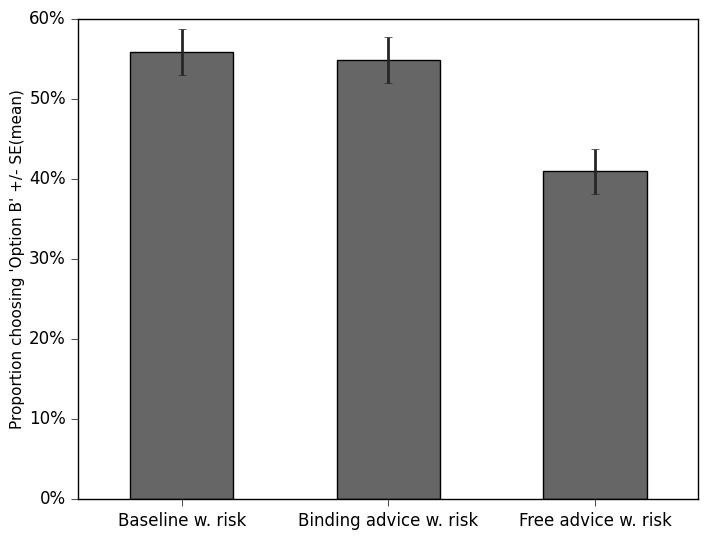

In [13]:
fig, ax = plt.subplots(
    figsize=(8, 6), 
    dpi=100, 
    facecolor='w'
)

decision_advice['mean'].plot(
    yerr=decision_advice['sem'], 
    ax=ax, 
    error_kw=error_kw, 
    **bar_kw
)

ax.set_ylabel("Proportion choosing 'Option B' +/- SE(mean)", **ylab_kw)
ax.set_xlabel("")
ax.set_xticklabels(['Baseline w. risk', 'Binding advice w. risk', 'Free advice w. risk'])
ax.tick_params(rotation=0, **tick_kw)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

path = os.path.join(
    FIGURES_FOLDER,  
    'decision_advice_risk.pdf'
)
fig.savefig(path, bbox_inches='tight')

#### Table 3: Estimating treatment effects using OLS <a id='decision'></a>

In [14]:
regs = dict()
regs['reg1'] = 'Decision ~ Binding + Free'
regs['reg2'] = regs['reg1'] + ' + Age_m + Female + Education_m + Political_m'

ols_results = [
    smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()
]

order = [
    'Binding',
    'Free',
    'Age_m',
    'Female',
    'Education_m',
    'Political_m',
    'Intercept',
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}',
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}'
}

ols_quant = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
)

ols_quant = ols_quant\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(':', ' * '), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('decision_numeric', 'p(selfish)'), axis=1)\
    .rename_axis('Dependent variable:', axis=1)

ols_quant.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_decision_risk.tex'),
    bold_rows=False,
    float_format="%.3f"
)

display(ols_quant)

/tmp/ipykernel_14000/879250448.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ols_quant.to_latex(


Dependent variable:,Decision,Decision
Binding,-0.010,-0.007
,(0.041),(0.041)
Free,-0.150***,-0.147***
,(0.041),(0.041)
Age_m,,0.000
,,(0.033)
Female,,-0.097***
,,(0.033)
Education_m,,0.005
,,(0.033)


#### Plot share of selfish choices, by gender

In [15]:
decision_gender = df.groupby(['Female', 'Advice_type'])['Decision']\
    .agg(['mean', 'sem', 'count'])\
    .rename({0:'Male', 1:'Female'}, axis=0, level=0)\
    .rename({'base': 'Baseline', 'binding':'Binding advice', 'free':'Free advice'}, axis=0, level=1)\
    .rename_axis(('Gender', 'Treatment'), axis=0)\
    .swaplevel()\
    .sort_index()

display(decision_gender)

mean    sem  count
Treatment Gender                     
Base      Female  0.535  0.042    142
          Male    0.580  0.040    157
Binding   Female  0.487  0.041    150
          Male    0.609  0.040    151
Free      Female  0.347  0.039    147
          Male    0.470  0.041    149

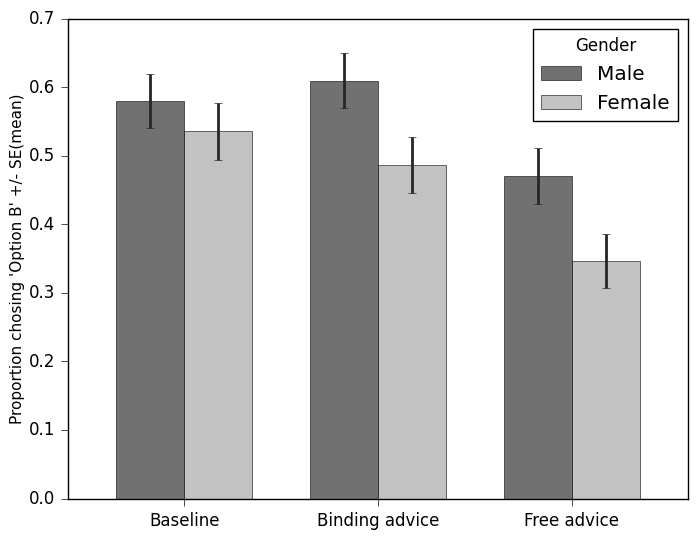

In [16]:
means = decision_gender\
    .loc[:, 'mean']\
    .unstack()\
    .sort_index(axis=1, ascending=False)

errors = decision_gender\
    .loc[:, 'sem']\
    .unstack()\
    .sort_index(axis=1, ascending=False)

fig, ax = plt.subplots(
    figsize=(8, 6), 
    dpi=100, 
    facecolor='w'
)

means.plot(
    yerr=errors, 
    ax=ax, 
    capsize=4, 
    kind='bar', 
    error_kw=error_kw, 
    color=['0.3', '0.7'], 
    alpha=0.8, 
    lw=0.5, 
    width=0.7
)

ax.set_ylabel("Proportion chosing 'Option B' +/- SE(mean)", **ylab_kw)
ax.set_xlabel("")
ax.set_xticklabels(['Baseline', 'Binding advice', 'Free advice'])
ax.tick_params(rotation=0, **tick_kw)

#### Estimating treatment effects, by gender

In [17]:
regs = dict()
regs['reg1'] = 'Decision ~ (Binding + Free) * Female'
regs['reg2'] = regs['reg1'] + ' + Age_m + Education_m + Political_m'

ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]

order = [
    'Binding',
    'Free',
    'Female',
    'Binding:Female',
    'Free:Female',
    'Intercept',
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}',
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}'
}

ols_quant = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
    drop_omitted=True,
)

ols_quant = ols_quant\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(':', ' * '), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('Decision', 'p(selfish)'), axis=1)\
    .rename_axis('Dependent variable', axis=1)

# #this is bad
h1 = ols_results[0].t_test('Binding + Binding:Female = 0')
h2 = ols_results[1].t_test('Binding + Binding:Female = 0')
h3 = ols_results[0].t_test('Free + Free:Female = 0')
h4 = ols_results[1].t_test('Free + Free:Female = 0')

ols_quant.loc['Binding + Binding:Female'] = pd.Series(
    [f'{h1.effect[0]:.3f}', f'{h2.effect[0]:.3f}'],
    index=ols_quant.columns
)
ols_quant.loc['sd1'] = pd.Series(
    [f'({h1.sd[0][0]:.3f})', f'({h2.sd[0][0]:.3f})'],
    index=ols_quant.columns
)
ols_quant.loc['Free + Free:Female'] = pd.Series(
    [f'{h3.effect[0]:.3f}', f'{h4.effect[0]:.3f}'],
    index=ols_quant.columns
)
ols_quant.loc['sd2'] = pd.Series(
    [f'({h3.sd[0][0]:.3f})', f'({h4.sd[0][0]:.3f})'],
    index=ols_quant.columns
)

ols_quant.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_decision_female_risk.tex'),
    bold_rows=False,
    float_format="%.3f",
    caption='Estimating the probability of player X to choose the selfish option, by gender',
    label='decision_female',
)

display(ols_quant)

/tmp/ipykernel_14000/857734367.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ols_quant.to_latex(


Dependent variable,p(selfish),p(selfish)
Binding,0.030,0.031
,(0.056),(0.056)
Free,-0.110*,-0.109*
,(0.057),(0.057)
Female,-0.044,-0.044
,(0.058),(0.058)
Binding * Female,-0.078,-0.079
,(0.081),(0.081)
Free * Female,-0.078,-0.079
,(0.081),(0.081)


#### Estimating treatment effects, Probit

In [18]:
regs = dict()
regs['reg1'] = 'Decision ~ Binding + Free'
regs['reg2'] = regs['reg1'] + ' + Age_m + Female + Education_m + Political_m'

probit_results = [smf.probit(formula=v, data=df).fit() for v in regs.values()]

order = [
    'Binding',
    'Free',
    'Age_m',
    'Female',
    'Education_m',
    'Political_m',
    'Intercept',
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'PR2': lambda x: f'{x.prsquared:.3f}',
}

probit_decision = summary_col(
    probit_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
)

probit_decision = probit_decision\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(':', ' * '), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('Decision', 'p(selfish)'), axis=1)\
    .rename_axis('Dependent variable:', axis=1)

probit_decision.to_latex(
    os.path.join(TABLES_FOLDER, 'probit_decision_risk.tex'),
    bold_rows=False,
    float_format="%.3f"
)

display(probit_decision)

Optimization terminated successfully.
         Current function value: 0.683766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678897
         Iterations 4


/tmp/ipykernel_14000/3326026956.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  probit_decision.to_latex(


Dependent variable:,p(selfish),p(selfish)
Binding,-0.026,-0.018
,(0.103),(0.103)
Free,-0.378***,-0.375***
,(0.103),(0.104)
Age_m,,0.000
,,(0.085)
Female,,-0.247***
,,(0.085)
Education_m,,0.012
,,(0.085)


#### Convert to html

In [19]:
!jupyter nbconvert --output-dir='./docs' --to html 3b_treatment_effects_risk.ipynb

[NbConvertApp] Converting notebook 3b_treatment_effects_risk.ipynb to html
[NbConvertApp] Writing 710243 bytes to docs/3b_treatment_effects_risk.html
